In [56]:
import sys
import platform
from os.path import join, exists, abspath, dirname
from os import getcwd, makedirs
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import scipy
from scipy.stats import ttest_1samp, ttest_rel
import seaborn as sns

from tqdm import tqdm

In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GroupKFold, cross_val_score

In [3]:
import nibabel as nb
from nilearn import plotting, image
from nilearn.maskers import NiftiLabelsMasker
from nilearn.decoding import Decoder
from nipype.interfaces import fsl

In [4]:
import subprocess
import warnings

In [5]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/Users/sungbeenpark/github'

In [6]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [7]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [8]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [9]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import stat as sstat
from SSS import plot as splt
from SSS import image as simage
from SSS import glmsingle as ssingle

---

In [10]:
dir_root = su.get_dir_root()
dir_root

'/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI'

In [11]:
list_sn = su.get_list_sn()

---

In [12]:
glm = 1
dir_glm = ssingle.get_dir_glmsingle(glm)

In [13]:
dir_surf = join(ssingle.get_dir_glmsingle(),'surfaceWB')
dir_surf

'/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI/GLMsingle/surfaceWB'

In [14]:
dir_group = join(dir_surf,'group')

---

In [15]:
dir_fs = su.get_dir_fs()

In [16]:
border, brdr = simage.get_border(join(dir_git,'surfAnalysisPy'))
hem = 'L'

In [17]:
## the label list of benson14
list_roi = ['V1','V2','V3','hV4','VO1','VO2','LO1','LO2','TO1','TO2','V3b','V3a']

---
---

## MVPA

In [18]:
def fast_masking(img_data, img_mask, roi):
    if isinstance(img_data,str):
        img_data = nb.load(img_data)
    img_data = img_data.get_fdata()

    if isinstance(img_mask,str):
        img_mask = nb.load(img_mask)
    img_mask = img_mask.get_fdata().astype(int)
    assert img_data.shape[:3] == img_mask.shape
    
    list_roi_ = np.array(list_roi)
    idx = int(np.where(list_roi_==roi)[0][0])
    assert isinstance(idx, int)
    
    idx_mask = img_mask==idx+1
    data = img_data[idx_mask].T
    
    return data

In [19]:
shuffle = True

In [20]:
lines = {'subj':[], 'roi':[], 'score':[]}

for ii, sn in enumerate(tqdm(list_sn)):
    subj = 'S'+sn

    ## labels
    reginfo = deal_spm.load_reginfo(subj, dir_glm)
    y = reginfo.name.values
    y = np.array(['spatial' if 'S' in cue else ('letter' if 'L' in cue else 'invalid') for cue in y])
    if shuffle:
        np.random.shuffle(y)
    group = reginfo.run.values

    ## beta
    list_img_data = sorted(glob(join(dir_glm,subj,'beta_*.nii')))

    ## mask
    dir_roi = join(dir_fs, subj, 'mri')
    img_mask = image.resample_to_img(
        source_img=join(dir_roi,'lh.benson14_varea.vol.nii'),
        target_img=list_img_data[0],
        interpolation='nearest',
        force_resample=True,
        copy_header=True
    )
    
    ## get masked beta
    for roi in list_roi:
        dataset = []
        for img_data in list_img_data:
            data = fast_masking(img_data, img_mask, roi)
            dataset.append(data)
        dataset = np.array(dataset)

        ## pipeline: scaling + SVM
        clf = make_pipeline(
            SimpleImputer(strategy='constant', fill_value=0, keep_empty_features=True),
            StandardScaler(),
            SVC(kernel='linear', C=1)
        )

        ## group fold
        gkf = GroupKFold(n_splits=len(np.unique(group)))

        ## run cross-validation
        scores = cross_val_score(estimator=clf, X=dataset, y=y, cv=gkf, groups=group)
        
        ## restore the result
        lines['subj'].append(subj)
        lines['roi'].append(roi)
        lines['score'].append(np.mean(scores))

df = pd.DataFrame(lines)
if shuffle:
    fname = join(dir_group, 'df.glm_%1d.MVPA.shuffled.csv'%glm)
else:
    fname = join(dir_group, 'df.glm_%1d.MVPA.csv'%glm)
df.to_csv(fname, index=False)
del lines

100%|████████████████████████████████████████| 12/12 [1:23:38<00:00, 418.21s/it]


---
---

## Load the result

In [25]:
shuffle = True

In [26]:
fname = join(dir_group, 'df.glm_%1d.MVPA.shuffled.csv'%glm)
df_shuf = pd.read_csv(fname, header=0)
fname = join(dir_group, 'df.glm_%1d.MVPA.csv'%glm)
df = pd.read_csv(fname, header=0)

In [28]:
df_shuf

,subj,roi,score
0,S01,V1,0.512868
1,S01,V2,0.523897
2,S01,V3,0.531250
3,S01,hV4,0.509191
4,S01,VO1,0.529412
...,...,...,...
139,S14,LO2,0.496324
140,S14,TO1,0.549632
141,S14,TO2,0.514706
142,S14,V3b,0.483456


In [27]:
df

,subj,roi,score
0,S01,V1,0.979779
1,S01,V2,0.988971
2,S01,V3,0.992647
3,S01,hV4,0.979779
4,S01,VO1,0.898897
...,...,...,...
139,S14,LO2,0.851103
140,S14,TO1,0.840074
141,S14,TO2,0.669118
142,S14,V3b,0.805147


In [63]:
# chance distribution 예시
chance_mean = df_shuf.groupby(['roi']).mean('score').score
chance_std  = df_shuf.groupby(['roi'])['score'].apply('sem')

V1 t(11)=47.1701, p=4.763e-14(****)
V2 t(11)=34.9434, p=1.265e-12(****)
V3 t(11)=60.2192, p=3.276e-15(****)
hV4 t(11)=54.0771, p=1.066e-14(****)
VO1 t(11)=16.3290, p=4.649e-09(****)
VO2 t(11)=6.4250, p=4.908e-05(****)
LO1 t(11)=13.2341, p=4.227e-08(****)
LO2 t(11)=12.1943, p=9.861e-08(****)
TO1 t(11)=8.1373, p=5.555e-06(****)
TO2 t(11)=6.1715, p=6.992e-05(****)
V3b t(11)=11.4254, p=1.923e-07(****)
V3a t(11)=23.7275, p=8.484e-11(****)


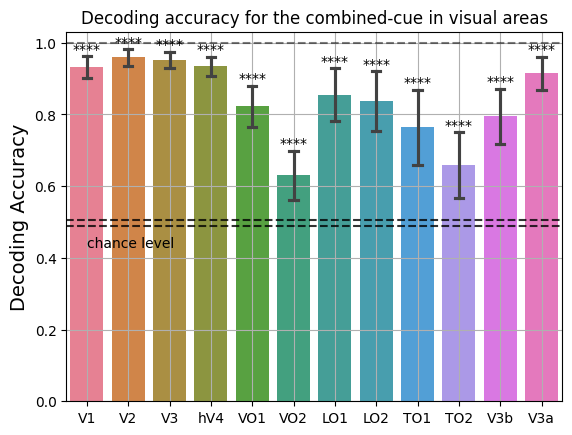

In [100]:
g = sns.barplot(
    data=df,
    x='roi', y='score', hue='roi',
    errorbar='sd', capsize=0.2
)
g.text(x=0., y=0.43, s='chance level', fontsize=10, ha='left')
g.axhline(y=1, linestyle='--', color='black', alpha=0.5)
g.grid(axis='both')
g.set_xlabel('')
g.set_ylabel('Decoding Accuracy', fontsize=14)
g.set_title('Decoding accuracy for the combined-cue in visual areas', fontsize=12)

## chance level
# g.axhline(y=0.5, linestyle='--', color='black', alpha=0.8)
y = chance_mean.mean()
dy = chance_std.mean()
g.axhline(y=y+dy, linestyle='--', color='black', alpha=0.8)
g.axhline(y=y-dy, linestyle='--', color='black', alpha=0.8)

## one sample t-test
dy = np.diff(g.get_ylim())*0.025

for ii, roi in enumerate(list_roi):
    # x = ii
    # dx = 0.4
    # y = chance_mean.loc[roi]
    # dy = chance_std.loc[roi]
    # g.plot([x-dx,x+dx], [y-dy, y-dy],'-', linewidth=2., color='black', alpha=0.4)
    # g.plot([x-dx,x+dx], [y+dy, y+dy],'-', linewidth=2., color='black', alpha=0.4)
    a = df[df.roi==roi].score.astype(float)
    b = df_shuf[df_shuf.roi==roi].score.astype(float)
    res = ttest_rel(a, b)
    if res.pvalue < 0.05:
        print(roi, 't(%d)=%.4f, p=%.3e(%s)'%(res.df,res.statistic,res.pvalue,sstat.convert_pval_to_star(res.pvalue)))
        x = ii
        y = a.mean()+a.std()
        g.text(
            x=x, y=y,
            s=sstat.convert_pval_to_star(res.pvalue), fontsize=10,
            ha='center', va='bottom'
        )

---